In [1]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import matplotlib.pyplot as plt

from pynfft import NFFT, Solver

import sys
sys.path.append("../..")
from mfilter.implementations.simulate import SimulateSignal
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples
from mfilter.filter import *
from microlensing import *

%matplotlib inline
plt.style.use('seaborn')

400 400 400


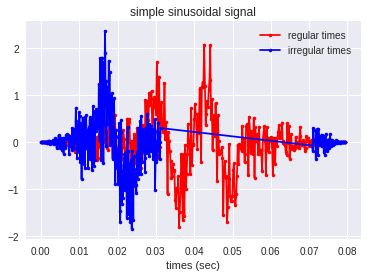

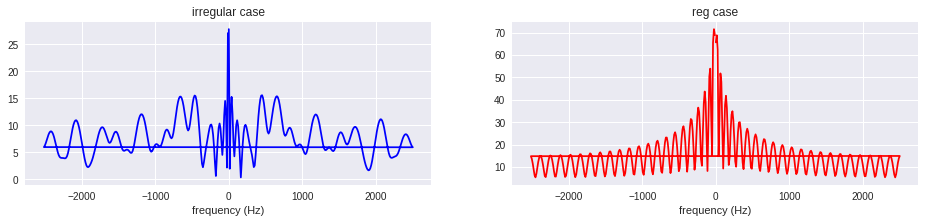

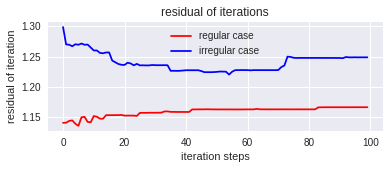

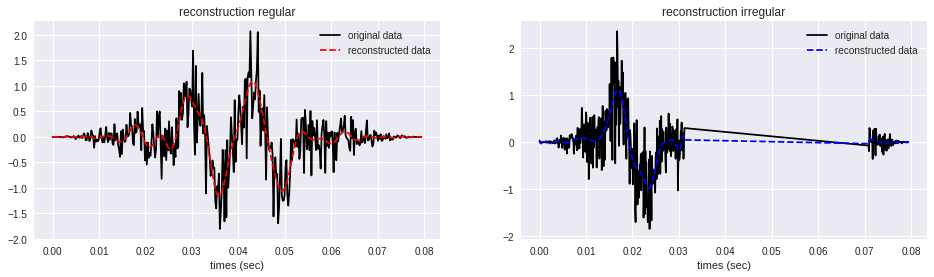

In [2]:
delta_t = 0.0001
n = 400
struct = "outlier"
ireg_time = TimesSamples(n=n, delta=delta_t, struct=struct)
reg_time = TimesSamples(initial_array=np.linspace(ireg_time.min(), ireg_time.max(), n))
freq = 1 / (ireg_time[2*int(n/3)] - (ireg_time[int(n/3)]))

window = signal.windows.hann(n)

reg_data = np.zeros(n)
reg_data[int(n/3):2*int(n/3)] = np.sin(2 * np.pi * freq * (reg_time[int(n/3):2*int(n/3)] - reg_time[int(n/3)]))
reg_data += np.random.normal(0, 0.6, n)
reg_data *= window

ireg_data = np.zeros(n)
ireg_data[int(n/3):2*int(n/3)] = np.sin(2 * np.pi * freq * (ireg_time[int(n/3):2*int(n/3)] - ireg_time[int(n/3)]))
ireg_data += np.random.normal(0, 0.6, n)
ireg_data *= window
plt.figure()
plt.plot(reg_time, reg_data, 'r.-', label="regular times")
plt.plot(ireg_time, ireg_data, 'b.-', label="irregular times")
plt.title("simple sinusoidal signal")
plt.xlabel("times (sec)")
plt.legend()

def do_solver(solv, data, k):
    solv.y = data
    solv.before_loop()
    count = 0
    r = []
    while (count < k):
        solv.loop_one_step()
        r.append(max(solv.r_iter))
        count += 1
    return solv.f_hat_iter, np.array(r)

factor = 1
reg_plan = NFFT(n*factor, n)
reg_plan.x = reg_time.value
reg_plan.precompute()
reg_plan.f = reg_data
reg_adj_ft = reg_plan.adjoint()
reg_solv = Solver(reg_plan)
# reg_solv.f_hat_iter = reg_adj_ft
reg_ft, reg_r_iter = do_solver(reg_solv, reg_data, 100)

ireg_plan = NFFT(n*factor, n)
ireg_plan.x = ireg_time.value
ireg_plan.precompute()
ireg_plan.f = ireg_data
ireg_adj_ft = ireg_plan.adjoint()
ireg_solv = Solver(ireg_plan)
# ireg_solv.f_hat_iter = ireg_adj_ft
ireg_ft, ireg_r_iter = do_solver(ireg_solv, ireg_data, 100)

print(n, len(reg_ft), len(ireg_ft))
freq = np.fft.fftfreq(n*factor, d=reg_time.duration / n)*factor
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3))
ax1.plot(freq, abs(ireg_ft), 'b')
# plt.plot(freq, ireg_ft.imag, 'r')
ax1.set_title("irregular case")
ax1.set_xlabel("frequency (Hz)")
ax2.plot(freq, abs(reg_ft), 'r')
# plt.plot(freq, reg_ft.imag, 'r')
# plt.xlim([0, 30])
ax2.set_title("reg case")
ax2.set_xlabel("frequency (Hz)")

plt.figure(figsize=(6, 2))
plt.title("residual of iterations")
plt.plot(reg_r_iter.real, 'r', label="regular case")
plt.plot(ireg_r_iter.real, 'b', label="irregular case")
plt.xlabel("iteration steps")
plt.ylabel("residual of iteration")
plt.legend()

reg2_plan = NFFT(n*factor, n)
reg2_plan.x = reg_time.value
reg2_plan.precompute()
reg2_plan.f_hat = reg_ft
reg_back = reg2_plan.trafo()

ireg2_plan = NFFT(n*factor, n)
ireg2_plan.x = ireg_time.value
ireg2_plan.precompute()
ireg2_plan.f_hat = ireg_ft
ireg_back = ireg2_plan.trafo()

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 4))
ax1.set_title("reconstruction regular")
ax1.plot(reg_time, reg_data, 'k', label="original data")
ax1.plot(reg_time, reg_back.real, 'r--', label="reconstructed data")
ax1.set_xlabel("times (sec)")
ax1.legend()
ax2.set_title("reconstruction irregular")
ax2.plot(ireg_time, ireg_data, 'k', label="original data")
ax2.plot(ireg_time, ireg_back.real, 'b--', label="reconstructed data")
ax2.set_xlabel("times (sec)")
ax2.legend()